# Topic modeling with Bertopic

In [1]:
pip install bertopic pandas numpy matplotlib plotly nbformat ipywidgets openpyxl nltk

Note: you may need to restart the kernel to use updated packages.


# Start 

In this tutorial, we will use the [`Bertopic`](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html) library to perform topic modeling on legislative text.


## Data

We will use a dataset of Donald Trump's tweets from 2009 to 2021. This dataset is available on [Kaggle](https://www.kaggle.com/datasets/austinreese/trump-tweets) and contains 43,000 tweets sent by Donald Trump. 

# Data Preprocessing

Social media messages are a common medium for applied computational methods and machine learning. However, they are often noisy and contain a lot of irrelevant information. In this tutorial, our aim is to use the `Bertopic` library to perform topic modeling on the tweets, but we first need to preprocess the data to remove any irrelevant information.


## What is topic modeling?

Topic modeling is a type of statistical model that is used to discover the abstract topics that occur in a collection of documents. It is an unsupervised machine learning technique that can be used to identify the main themes or topics in a large collection of text documents. We will use the `Bertopic` library, which relies on the BERT language model to perform topic modeling.

We expect that the tweets can be grouped into topics that correspond to the different areas of focus. Moreover, the data have a temporal dimension, which we will use to create dynamic topic models. While we will be focusing on the tweets of Donald Trump, the techniques we will use can be applied to any text data.

In [2]:
import pandas as pd 
import numpy as np 
from bertopic import BERTopic

In [3]:
# read in the data

df = pd.read_csv('../data/trump_tweets.csv')
df

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN
...,...,...,...,...,...,...,...,...
43347,1273405198698975232,https://twitter.com/realDonaldTrump/status/127...,Joe Biden was a TOTAL FAILURE in Government. H...,2020-06-17 19:00:32,23402,116377,NaN,NaN
43348,1273408026968457216,https://twitter.com/realDonaldTrump/status/127...,Will be interviewed on @ seanhannity tonight a...,2020-06-17 19:11:47,11810,56659,@seanhannity,NaN
43349,1273442195161387008,https://twitter.com/realDonaldTrump/status/127...,pic.twitter.com/3lm1spbU8X,2020-06-17 21:27:33,4959,19344,NaN,NaN
43350,1273442469066276864,https://twitter.com/realDonaldTrump/status/127...,pic.twitter.com/vpCE5MadUz,2020-06-17 21:28:38,4627,17022,NaN,NaN


In [4]:
# what does the text look like? 

df['content'].sample(20).values

array(['" @ chpnaput: Donald, you need to promote the GILC, it is a great event and shows off Doonbeg. Best resort I have ever stayed at!"',
       '“Money was never a big motivation for me, except as a way to keep score.The excitement is playing the game.”–The Art of The Deal',
       'We stand in absolute solidarity with the people of the United Kingdom.pic.twitter.com/X6fUUxxYXE',
       'Univision apologized to me but I will not accept their apology. I will be suing them for a lot of money. Miss U.S.A. contestants are hurt!',
       '" @ James_Taylor78: @ realDonaldTrump You\'d have my vote!" Great.',
       'Little Marco Rubio, the lightweight no show Senator from Florida, is set to be the "puppet" of the special interest Koch brothers. WATCH!',
       'So now the Obama appointed judge on the Census case (Are you a Citizen of the United States?) won’t let the Justice Department use the lawyers that it wants to use. Could this be a first?',
       "The San Fran crash was totally th

In [5]:
# what is the length of the text data we are working with?

df['content'].str.len().describe()

count    43352.000000
mean       131.525927
std         63.052228
min          4.000000
25%         93.000000
50%        130.000000
75%        142.000000
max        406.000000
Name: content, dtype: float64

<Axes: >

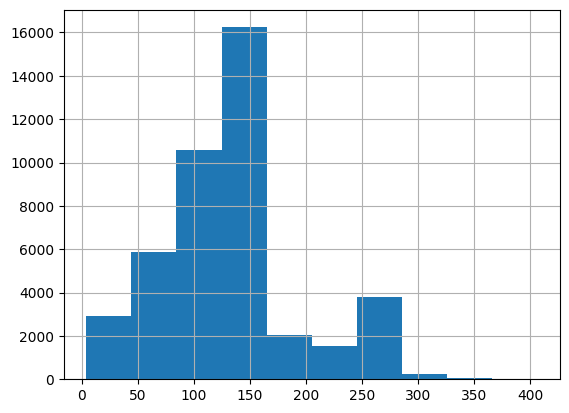

In [6]:
df['content'].str.len().hist()

In [7]:
# Let's prepare the data for BERTopic - discuss options for cleaning the text

# remove pics and videos - this does not work as expected - https://stackoverflow.com/questions/59970396/how-to-remove-picture-url-from-twitter-tweet-using-python
df['content'] = df['content'].str.replace(r'pic.twitter.com/[\w]*',"", regex=True)

In [8]:
# remove special characters
df['content'] = df['content'].str.replace(r'[^\w\s]', '', regex=True)

In [9]:
# remove numbers
df['content'] = df['content'].str.replace(r'\d+', '', regex=True)

In [10]:
# remove stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))

[nltk_data] Downloading package stopwords to /home/zach/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# remove social media handles that start with @
df['content'] = df['content'].str.replace(r'@\w+', '', regex=True)

In [12]:
# remove urls 
df['content'] = df['content'].str.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'https\S+', '', regex=True)

In [13]:
df

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,sure tune watch Donald Trump Late Night David ...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump appearing View tomorrow morning d...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips Late...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post Celebrity Apprentice Finale Less...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,persona never wallflower Id rather build walls...,2009-05-12 09:07:28,1375,1945,NaN,NaN
...,...,...,...,...,...,...,...,...
43347,1273405198698975232,https://twitter.com/realDonaldTrump/status/127...,Joe Biden TOTAL FAILURE Government bungled eve...,2020-06-17 19:00:32,23402,116377,NaN,NaN
43348,1273408026968457216,https://twitter.com/realDonaldTrump/status/127...,interviewed seanhannity tonight PM Enjoy,2020-06-17 19:11:47,11810,56659,@seanhannity,NaN
43349,1273442195161387008,https://twitter.com/realDonaldTrump/status/127...,,2020-06-17 21:27:33,4959,19344,NaN,NaN
43350,1273442469066276864,https://twitter.com/realDonaldTrump/status/127...,,2020-06-17 21:28:38,4627,17022,NaN,NaN


In [14]:
# drop the rows with empty content
df = df[df['content'] != '']

In [15]:
# drop the rows with fewer than 5 words 
df = df[df['content'].str.split().str.len() > 6]

In [16]:
df

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,sure tune watch Donald Trump Late Night David ...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump appearing View tomorrow morning d...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips Late...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post Celebrity Apprentice Finale Less...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,persona never wallflower Id rather build walls...,2009-05-12 09:07:28,1375,1945,NaN,NaN
...,...,...,...,...,...,...,...,...
43341,1273032175718449155,https://twitter.com/realDonaldTrump/status/127...,Chris Jacobs JacobsNY tremendous Congressman a...,2020-06-16 18:18:17,9802,35418,@JacobsNY27,#NY27https
43342,1273034110353707008,https://twitter.com/realDonaldTrump/status/127...,Congressman LeeZeldin fighter New York serves ...,2020-06-16 18:25:58,12070,45048,@LeeZeldin,NaN
43343,1273038952275095558,https://twitter.com/realDonaldTrump/status/127...,LyndaBennettNC Complete Total Endorsement grea...,2020-06-16 18:45:12,10263,37476,@LyndaBennettNC,NaN
43345,1273080720794279937,https://twitter.com/realDonaldTrump/status/127...,GREAT woman son looking heaven proud wonderful...,2020-06-16 21:31:11,26468,112140,NaN,NaN


# Let's fit a topic model to the data 

In [17]:
# Bertopic requires a list of strings as input.
# 
# We'll call this list of strings 'documents'

documents = df['content'].tolist()

documents[0:10]

['sure tune watch Donald Trump Late Night David Letterman presents Top Ten List tonight',
 'Donald Trump appearing View tomorrow morning discuss Celebrity Apprentice new book Think Like Champion',
 'Donald Trump reads Top Ten Financial Tips Late Show David Letterman  funny',
 'New Blog Post Celebrity Apprentice Finale Lessons Learned Along Way ',
 'persona never wallflower Id rather build walls cling Donald J Trump',
 'Miss USA Tara Conner fired Ive always believer second chances says Donald Trump',
 'Listen interview Donald Trump discussing new book Think Like Champion ',
 'Strive wholeness keep sense wonder intact Donald J Trump ',
 'Enter Think Like Champion signed book keychain contest ',
 'achiever achieves plateau beginning Donald J Trump ']

In [18]:
# create a BERTopic model
topic_model = BERTopic()

# fit the model to the data
topics, probs = topic_model.fit_transform(documents)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [19]:
# After generating topics, we can access the frequent topics that were generated

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14644,-1_realdonaldtrump_trump_great_thank,"[realdonaldtrump, trump, great, thank, donald,...",[Many Republican voters showed yesterday Fake ...
1,0,851,0_run_please_needs_president,"[run, please, needs, president, vote, country,...",[_xx_justme realDonaldTrump realDonaldTrump th...
2,1,773,1_china_trade_tariffs_chinese,"[china, trade, tariffs, chinese, chinas, farme...",[Farmers well years Mexico Canada China others...
3,2,363,2_foxandfriends_foxnews_fox_megynkelly,"[foxandfriends, foxnews, fox, megynkelly, bell...",[belllabooo foxandfriends Always watch Mr Trum...
4,3,290,3_poll_polls_lead_carson,"[poll, polls, lead, carson, debate, numbers, i...",[Great poll numbers coming New Hampshire BIG l...
...,...,...,...,...,...
411,410,10,410_mikeandmike_frankcaliendo_funny_segment,"[mikeandmike, frankcaliendo, funny, segment, k...",[jimhewitt FrankCaliendo realDonaldTrump MikeA...
412,411,10,411_california_cox_gavinnewsom_governor,"[california, cox, gavinnewsom, governor, hoopl...",[California rare opportunity turn things aroun...
413,412,10,412_hillaryclinton_debates_debate_nightcrooked,"[hillaryclinton, debates, debate, nightcrooked...",[really enjoyed debate last nightCrooked Hilla...
414,413,10,413_witnesses_trial_witness_freak,"[witnesses, trial, witness, freak, substanceco...",[Democrats gave Due Process House lawyers witn...


In [20]:

# create a BERTopic model
topic_model = BERTopic(nr_topics=20)

# fit the model to the data
topics, probs = topic_model.fit_transform(documents)

In [21]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14060,-1_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, peo...",[Many Republican voters showed yesterday Fake ...
1,0,11336,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, wou...",[nice call new President Ukraine could better ...
2,1,1582,1_golf_trump_course_macys,"[golf, trump, course, macys, hotel, doral, sco...",[Congratulations Aberdeen Scotland great golf ...
3,2,1379,2_border_wall_mexico_ebola,"[border, wall, mexico, ebola, people, immigrat...",[day one said going build great wall SOUTHERN ...
4,3,1345,3_korea_north_great_honor,"[korea, north, great, honor, today, thank, joi...",[Mike Pompeo met Kim Jong Un North Korea last ...
5,4,1257,4_china_us_trade_jobs,"[china, us, trade, jobs, tariffs, market, amer...",[many years China many countries taking advant...
6,5,868,5_iran_syria_isis_obama,"[iran, syria, isis, obama, iraq, us, israel, d...",[saying MANY years phony negotiate US nuclear ...
7,6,780,6_entrepreneurs_think_keep_focus,"[entrepreneurs, think, keep, focus, big, succe...",[Entrepreneurs Look solution problem Learn foc...
8,7,654,7_yankees_nfl_wwe_nflcommish,"[yankees, nfl, wwe, nflcommish, arod, great, h...","[Via WWE Donald Trump announced WWE Hall Fame,..."
9,8,389,8_fed_reserve_interest_rates,"[fed, reserve, interest, rates, debt, federal,...",[Manufacturers held back strong Dollar propped...


In [22]:
topic_model.get_topic(16)

[('lordsugar', np.float64(0.46276912626249206)),
 ('sugar', np.float64(0.367455351839872)),
 ('dopey', np.float64(0.2528823234273416)),
 ('worth', np.float64(0.0789051788812751)),
 ('show', np.float64(0.07871981577814773)),
 ('piersmorgan', np.float64(0.06849305708454584)),
 ('money', np.float64(0.05232575802064914)),
 ('ipod', np.float64(0.05198320022138063)),
 ('cant', np.float64(0.04859078800648244)),
 ('making', np.float64(0.04791353744278502))]

In [23]:
# -1 refers to all outliers and should typically be ignored.

# Using .get_document_info, we can also extract information on a document level, 
# such as their corresponding topics, probabilities, whether they are representative documents for a topic, etc.:

topic_model.get_document_info(documents)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,sure tune watch Donald Trump Late Night David ...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, wou...",[nice call new President Ukraine could better ...,realdonaldtrump - trump - great - president - ...,0.252498,False
1,Donald Trump appearing View tomorrow morning d...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, wou...",[nice call new President Ukraine could better ...,realdonaldtrump - trump - great - president - ...,0.469464,False
2,Donald Trump reads Top Ten Financial Tips Late...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, wou...",[nice call new President Ukraine could better ...,realdonaldtrump - trump - great - president - ...,0.297291,False
3,New Blog Post Celebrity Apprentice Finale Less...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, wou...",[nice call new President Ukraine could better ...,realdonaldtrump - trump - great - president - ...,0.514401,False
4,persona never wallflower Id rather build walls...,-1,-1_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, peo...",[Many Republican voters showed yesterday Fake ...,realdonaldtrump - trump - great - president - ...,0.000000,False
...,...,...,...,...,...,...,...,...
34474,Chris Jacobs JacobsNY tremendous Congressman a...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, wou...",[nice call new President Ukraine could better ...,realdonaldtrump - trump - great - president - ...,0.761172,False
34475,Congressman LeeZeldin fighter New York serves ...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, wou...",[nice call new President Ukraine could better ...,realdonaldtrump - trump - great - president - ...,0.456632,False
34476,LyndaBennettNC Complete Total Endorsement grea...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, wou...",[nice call new President Ukraine could better ...,realdonaldtrump - trump - great - president - ...,0.436460,False
34477,GREAT woman son looking heaven proud wonderful...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, wou...",[nice call new President Ukraine could better ...,realdonaldtrump - trump - great - president - ...,1.000000,False


In [24]:
# We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other. To visualize this hierarchy, run the following:

topic_model.visualize_barchart(top_n_topics=20)

# Visualizing the topics

In [25]:
topic_model.visualize_topics()

In [26]:
# Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other. To visualize the heatmap, run the following:

topic_model.visualize_heatmap()

In [27]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14060,-1_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, peo...",[Many Republican voters showed yesterday Fake ...
1,0,11336,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, wou...",[nice call new President Ukraine could better ...
2,1,1582,1_golf_trump_course_macys,"[golf, trump, course, macys, hotel, doral, sco...",[Congratulations Aberdeen Scotland great golf ...
3,2,1379,2_border_wall_mexico_ebola,"[border, wall, mexico, ebola, people, immigrat...",[day one said going build great wall SOUTHERN ...
4,3,1345,3_korea_north_great_honor,"[korea, north, great, honor, today, thank, joi...",[Mike Pompeo met Kim Jong Un North Korea last ...
5,4,1257,4_china_us_trade_jobs,"[china, us, trade, jobs, tariffs, market, amer...",[many years China many countries taking advant...
6,5,868,5_iran_syria_isis_obama,"[iran, syria, isis, obama, iraq, us, israel, d...",[saying MANY years phony negotiate US nuclear ...
7,6,780,6_entrepreneurs_think_keep_focus,"[entrepreneurs, think, keep, focus, big, succe...",[Entrepreneurs Look solution problem Learn foc...
8,7,654,7_yankees_nfl_wwe_nflcommish,"[yankees, nfl, wwe, nflcommish, arod, great, h...","[Via WWE Donald Trump announced WWE Hall Fame,..."
9,8,389,8_fed_reserve_interest_rates,"[fed, reserve, interest, rates, debt, federal,...",[Manufacturers held back strong Dollar propped...


# Dynamic topic modeling 

In [28]:
# create date column 
df['date'] = pd.to_datetime(df['date'])


# create two lists, one for date and one for text 

dates = df['date'].dt.year.tolist()
texts = df['content'].tolist()

In [29]:
# define and fit the model
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(texts)

# add the time dimension to the topics
topics_over_time = topic_model.topics_over_time(texts, dates, nr_bins=20)

In [30]:
# visualize the topics over time
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

# Handling topic names 

Our topic names are not the most informative, and we might want to re-label them to be more informative. We can do this by using several different methods

In [31]:
# define and fit the model
topic_model = BERTopic(verbose=True, nr_topics=50)
topics, probs = topic_model.fit_transform(texts)

2025-02-03 09:45:46,468 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1078 [00:00<?, ?it/s]

2025-02-03 09:45:51,587 - BERTopic - Embedding - Completed ✓
2025-02-03 09:45:51,587 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-03 09:45:54,940 - BERTopic - Dimensionality - Completed ✓
2025-02-03 09:45:54,941 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-03 09:45:55,455 - BERTopic - Cluster - Completed ✓
2025-02-03 09:45:55,455 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-03 09:45:55,727 - BERTopic - Representation - Completed ✓
2025-02-03 09:45:55,728 - BERTopic - Topic reduction - Reducing number of topics
2025-02-03 09:45:55,902 - BERTopic - Topic reduction - Reduced number of topics from 390 to 50


In [32]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,12027,-1_great_trump_realdonaldtrump_thank,"[great, trump, realdonaldtrump, thank, people,...",[bad Economic times worse better anything make...
1,0,5123,0_realdonaldtrump_trump_run_president,"[realdonaldtrump, trump, run, president, donal...",[B_Thornton run president youd vote Youre coun...
2,1,3511,1_fake_news_hillary_poll,"[fake, news, hillary, poll, media, collusion, ...",[Republican Party GREAT day yesterday respect ...
3,2,1734,2_apprentice_apprenticenbc_celebrity_show,"[apprentice, apprenticenbc, celebrity, show, t...",[Dont forget tune tonight another exciting epi...
4,3,1379,3_china_trade_us_tariffs,"[china, trade, us, tariffs, jobs, chinese, dea...",[many years China many countries taking advant...
5,4,1212,4_obamacare_obama_barackobama_tax,"[obamacare, obama, barackobama, tax, cuts, dac...",[immediately repeal replace ObamaCare nobody l...
6,5,1125,5_golf_hotel_course_trump,"[golf, hotel, course, trump, scotland, doral, ...",[spent two days Ireland Trump International Go...
7,6,972,6_endorsement_vets_amendment_great,"[endorsement, vets, amendment, great, carolina...",[Congressman MikeTurnerOH strong supporter fig...
8,7,967,7_border_wall_mexico_immigration,"[border, wall, mexico, immigration, southern, ...",[State Emergency Southern Border Border Patrol...
9,8,871,8_iran_isis_syria_iraq,"[iran, isis, syria, iraq, israel, obama, nucle...",[Iran wants fight official end Iran Never thre...


In [33]:
# the easiest way to generate topic labels is to use the generate_topic_labels method

topic_model.generate_topic_labels(nr_words=10,topic_prefix=False,word_length=15,separator=", ")

['great, trump, realdonaldtrump, thank, people, donald, get, obama, president, big',
 'realdonaldtrump, trump, run, president, donald, thanks, mr, please, need, country',
 'fake, news, hillary, poll, media, collusion, democrats, clinton, crooked, hunt',
 'apprentice, apprenticenbc, celebrity, show, tonight, interview, realdonaldtrump, pm, season, nbc',
 'china, trade, us, tariffs, jobs, chinese, deal, america, companies, country',
 'obamacare, obama, barackobama, tax, cuts, daca, debt, healthcare, republicans, repeal',
 'golf, hotel, course, trump, scotland, doral, club, links, tower, best',
 'endorsement, vets, amendment, great, carolina, complete, strong, iowa, military, total',
 'border, wall, mexico, immigration, southern, security, democrats, borders, laws, country',
 'iran, isis, syria, iraq, israel, obama, nuclear, us, benghazi, iranian',
 'entrepreneurs, think, focus, midas, touch, success, keep, big, work, champion',
 'honor, veterans, today, women, men, christmas, happy, hero

## More advanced: use a language model to generate topic names

In [34]:
topic_names = topic_model.generate_topic_labels(nr_words=10,topic_prefix=False,word_length=15,separator=", ")
topic_names

['great, trump, realdonaldtrump, thank, people, donald, get, obama, president, big',
 'realdonaldtrump, trump, run, president, donald, thanks, mr, please, need, country',
 'fake, news, hillary, poll, media, collusion, democrats, clinton, crooked, hunt',
 'apprentice, apprenticenbc, celebrity, show, tonight, interview, realdonaldtrump, pm, season, nbc',
 'china, trade, us, tariffs, jobs, chinese, deal, america, companies, country',
 'obamacare, obama, barackobama, tax, cuts, daca, debt, healthcare, republicans, repeal',
 'golf, hotel, course, trump, scotland, doral, club, links, tower, best',
 'endorsement, vets, amendment, great, carolina, complete, strong, iowa, military, total',
 'border, wall, mexico, immigration, southern, security, democrats, borders, laws, country',
 'iran, isis, syria, iraq, israel, obama, nuclear, us, benghazi, iranian',
 'entrepreneurs, think, focus, midas, touch, success, keep, big, work, champion',
 'honor, veterans, today, women, men, christmas, happy, hero

In [35]:
pip install openai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [36]:
# import openai API 
from openai import OpenAI


# create an instance of the OpenAI class - we're not going to use the API key, but it is required
client = OpenAI(
    base_url='http://localhost:11434/v1/',
    api_key='ollama',  # Required but ignored
)

In [37]:

# define the model we want to use
model = 'mistral'


# write a function that takes a string as input and returns the chatbot's response
def chat(text): 
    chat_completion = client.chat.completions.create(
        messages=[
            {'role': 'user', 'content': text},
        ],
        model=model, 
    )
    
    response = chat_completion.choices[0].message.content
    
    # print the response with line breaks
    print(response)
    return response

In [38]:
chat(f''' I am going to give you the topic representation words for a topic model. I want you to generate a label for the topic. Please only reply with a label for the topic. Here are the words: 
     
     \n \n 
     
        {topic_names[2]}
        
        
     \n \n    

    
        
    ''')

 Potential label for this topic: Political News Surrounding Clinton

By using the provided list of words that focus on Hillary Clinton (e.g., Clinton, democrats), political news (e.g., news, poll) and controversy or criticism (e.g., fake news, collusion, crooked), it's apparent that this topic might revolve around the political news pertaining to Hillary Clinton.


" Potential label for this topic: Political News Surrounding Clinton\n\nBy using the provided list of words that focus on Hillary Clinton (e.g., Clinton, democrats), political news (e.g., news, poll) and controversy or criticism (e.g., fake news, collusion, crooked), it's apparent that this topic might revolve around the political news pertaining to Hillary Clinton."

In [39]:
from tqdm import tqdm

In [70]:
new_llm_topic_names = []

for i in tqdm(topic_names): 
    response = chat(f''' I am going to give you the topic representation words from a topic model. I want you to generate a single label for the topic that consists of 3-5 words. Please only reply with a label for the topic. Here are the words: 
     
     \n \n 
     
        {i}
        
        
     \n \n    

    
        
    ''')
    
    new_llm_topic_names.append(response)

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

 "Popular Opinion on Trump's Presidency (Transition from Obama)"


  4%|▍         | 2/50 [00:01<00:40,  1.17it/s]

 "Political Actions of President Trump" (or, alternatively, "Trump's Presidency Requests")


  6%|▌         | 3/50 [00:02<00:27,  1.69it/s]

 "Political Media Misinformation Scandal (Hillary Clinton)"


  8%|▊         | 4/50 [00:02<00:21,  2.11it/s]

 "Celebrity Interview: Real Donald Trump Season on NBC"


 10%|█         | 5/50 [00:02<00:17,  2.55it/s]

 "U.S.-China Trade Tariffs Impacts"


 12%|█▏        | 6/50 [00:03<00:17,  2.45it/s]

 "Obama's Healthcare Policies & Tax Debate Among Republicans (including DACA & Debt)"


 14%|█▍        | 7/50 [00:03<00:14,  2.89it/s]

 "Scottish Golf Resorts and Trump Properties"


 18%|█▊        | 9/50 [00:03<00:12,  3.21it/s]

 "Military Endorsements for Carolina Constitutional Amendments - Complete and Strong Support from Iowa Vets"
 "Border Security and Immigration Policies"


 20%|██        | 10/50 [00:04<00:11,  3.42it/s]

 Middle East Conflicts & Nuclear Tensions under Obama


 24%|██▍       | 12/50 [00:04<00:09,  4.11it/s]

 "Midas Touch Successful Entrepreneurship"
 "Happy Christmas Honoring Veterans"


 26%|██▌       | 13/50 [00:04<00:09,  3.91it/s]

 WWE-Miss Universe USA Connection (Pageants and Wrestling Events)


 28%|██▊       | 14/50 [00:05<00:09,  3.72it/s]

 Natural Disaster Response in Puerto Rico (Including Law Enforcement)


 32%|███▏      | 16/50 [00:05<00:08,  4.03it/s]

 "Federal Monetary Policy Impact on Market and Inflation"
 Crippled Art Book Launch and Reading Event


 34%|███▍      | 17/50 [00:05<00:07,  4.47it/s]

 "New York Political Scandals"


 38%|███▊      | 19/50 [00:06<00:06,  4.50it/s]

 Global Health Crises (Viruses in Africa and US)
 North Korea-South Korea Nuclear Tensions


 42%|████▏     | 21/50 [00:06<00:06,  4.48it/s]

 "Protest in NFL Buffalo Bills Game: Tom Brady and Anthem Dispute"
 Wind Energy Conflict in Scotland


 44%|████▍     | 22/50 [00:07<00:07,  3.54it/s]

 "Famous MLB Players: Jeter, A-Rod, and the New York Yankees"


 46%|████▌     | 23/50 [00:07<00:07,  3.80it/s]

 Passionate Leaders and Scientific Pioneers


 48%|████▊     | 24/50 [00:07<00:08,  2.92it/s]

 "Celebrity Apprentice All-Star Season with Omarosa, Gary Busey, and Leeza Gibbons"


 52%|█████▏    | 26/50 [00:08<00:06,  3.56it/s]

 "Celebrity-Involved NBA Games in Cuba"
 Urban Restructuring and Business Philanthropy


 56%|█████▌    | 28/50 [00:08<00:05,  3.74it/s]

 "Global Coldest Record Weather Change (Climate Warming, Freezing)"
 "Colorado & Phoenix Sports Events Tomorrow"


 58%|█████▊    | 29/50 [00:09<00:05,  3.79it/s]

 Republican Presidential Candidates' Interviews and Discussions


 60%|██████    | 30/50 [00:09<00:05,  3.56it/s]

 "Military Scandals in Vietnam: Generals and Sexual Misconduct"


 64%|██████▍   | 32/50 [00:09<00:04,  4.19it/s]

 Food & Restaurant Reviews (Vanity Fair)
 Social Media Debates & OWS Protests


 68%|██████▊   | 34/50 [00:10<00:03,  4.40it/s]

 Vaccine Awareness and Autism Concerns in Children
 Parental Guidance and Wisdom


 70%|███████   | 35/50 [00:10<00:03,  3.85it/s]

 "Sugary Beverages Debate: Sugar Consumption and Weight Issues"


 72%|███████▏  | 36/50 [00:10<00:03,  3.90it/s]

 European Trade & Economic Cooperation (NATO Countries)


 74%|███████▍  | 37/50 [00:11<00:03,  3.57it/s]

 "Donald Trump's Million Dollar Song Hit (associated with Mac Miller)"


 76%|███████▌  | 38/50 [00:11<00:03,  3.25it/s]

 "Political Convention on Myrtle Beach (Monday), featuring Donald GOP"


 78%|███████▊  | 39/50 [00:12<00:03,  3.06it/s]

 "Venezuelan Political Conflict: Chávez, Maduro, Guaidó"


 80%|████████  | 40/50 [00:12<00:03,  3.18it/s]

 "Terrorist Attack in Paris (Security and Global Relations)"


 82%|████████▏ | 41/50 [00:12<00:02,  3.50it/s]

 "Competitive Financial Gaming Momentum"


 84%|████████▍ | 42/50 [00:12<00:02,  3.61it/s]

 "Political Activism among College Students in Las Vegas"


 88%|████████▊ | 44/50 [00:13<00:01,  4.02it/s]

 "Large Apple Devices Comparison (Apple vs Samsung)"
 Lance Armstrong Scandals and Interviews


 90%|█████████ | 45/50 [00:13<00:01,  3.86it/s]

 "Washington D.C. Amazon Retail Tax Lobbying"


 92%|█████████▏| 46/50 [00:13<00:01,  3.47it/s]

 Dissatisfied Cell Service Consumers (T-Mobile vs Verizon Wireless)


 94%|█████████▍| 47/50 [00:14<00:00,  3.36it/s]

 "Pinehurst Golf Experience: Matt Ginella, Steven Well Review"


 96%|█████████▌| 48/50 [00:14<00:00,  3.47it/s]

 "Facebook Videos / Latest Questions Answers"


 98%|█████████▊| 49/50 [00:14<00:00,  3.68it/s]

 Political News Analysis (Politics, Media, Analysis)


100%|██████████| 50/50 [00:14<00:00,  3.35it/s]

 "Reality TV Personalities & Hair Discussions"


In [71]:
new_llm_topic_names

[' "Popular Opinion on Trump\'s Presidency (Transition from Obama)"',
 ' "Political Actions of President Trump" (or, alternatively, "Trump\'s Presidency Requests")',
 ' "Political Media Misinformation Scandal (Hillary Clinton)"',
 ' "Celebrity Interview: Real Donald Trump Season on NBC"',
 ' "U.S.-China Trade Tariffs Impacts"',
 ' "Obama\'s Healthcare Policies & Tax Debate Among Republicans (including DACA & Debt)"',
 ' "Scottish Golf Resorts and Trump Properties"',
 ' "Military Endorsements for Carolina Constitutional Amendments - Complete and Strong Support from Iowa Vets"',
 ' "Border Security and Immigration Policies"',
 ' Middle East Conflicts & Nuclear Tensions under Obama',
 ' "Midas Touch Successful Entrepreneurship"',
 ' "Happy Christmas Honoring Veterans"',
 ' WWE-Miss Universe USA Connection (Pageants and Wrestling Events)',
 ' Natural Disaster Response in Puerto Rico (Including Law Enforcement)',
 ' "Federal Monetary Policy Impact on Market and Inflation"',
 ' Crippled Art 

In [72]:
topics = topic_model.get_topic_info()
topics['refined_topic_names'] = new_llm_topic_names

In [73]:
topics

,Topic,Count,Name,Representation,Representative_Docs,refined_topic_names
0,-1,12027,-1_great_trump_realdonaldtrump_thank,"[great, trump, realdonaldtrump, thank, people,...",[bad Economic times worse better anything make...,"""Popular Opinion on Trump's Presidency (Trans..."
1,0,5123,0_realdonaldtrump_trump_run_president,"[realdonaldtrump, trump, run, president, donal...",[B_Thornton run president youd vote Youre coun...,"""Political Actions of President Trump"" (or, a..."
2,1,3511,1_fake_news_hillary_poll,"[fake, news, hillary, poll, media, collusion, ...",[Republican Party GREAT day yesterday respect ...,"""Political Media Misinformation Scandal (Hill..."
3,2,1734,2_apprentice_apprenticenbc_celebrity_show,"[apprentice, apprenticenbc, celebrity, show, t...",[Dont forget tune tonight another exciting epi...,"""Celebrity Interview: Real Donald Trump Seaso..."
4,3,1379,3_china_trade_us_tariffs,"[china, trade, us, tariffs, jobs, chinese, dea...",[many years China many countries taking advant...,"""U.S.-China Trade Tariffs Impacts"""
5,4,1212,4_obamacare_obama_barackobama_tax,"[obamacare, obama, barackobama, tax, cuts, dac...",[immediately repeal replace ObamaCare nobody l...,"""Obama's Healthcare Policies & Tax Debate Amo..."
6,5,1125,5_golf_hotel_course_trump,"[golf, hotel, course, trump, scotland, doral, ...",[spent two days Ireland Trump International Go...,"""Scottish Golf Resorts and Trump Properties"""
7,6,972,6_endorsement_vets_amendment_great,"[endorsement, vets, amendment, great, carolina...",[Congressman MikeTurnerOH strong supporter fig...,"""Military Endorsements for Carolina Constitut..."
8,7,967,7_border_wall_mexico_immigration,"[border, wall, mexico, immigration, southern, ...",[State Emergency Southern Border Border Patrol...,"""Border Security and Immigration Policies"""
9,8,871,8_iran_isis_syria_iraq,"[iran, isis, syria, iraq, israel, obama, nucle...",[Iran wants fight official end Iran Never thre...,Middle East Conflicts & Nuclear Tensions unde...


In [74]:
# use the new topic names to visualize the topics 


# create df from model 
topic_df = topic_model.get_document_info(documents)
topic_df

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,sure tune watch Donald Trump Late Night David ...,2,2_apprentice_apprenticenbc_celebrity_show,"[apprentice, apprenticenbc, celebrity, show, t...",[Dont forget tune tonight another exciting epi...,apprentice - apprenticenbc - celebrity - show ...,0.420393,False
1,Donald Trump appearing View tomorrow morning d...,-1,-1_great_trump_realdonaldtrump_thank,"[great, trump, realdonaldtrump, thank, people,...",[bad Economic times worse better anything make...,great - trump - realdonaldtrump - thank - peop...,0.000000,False
2,Donald Trump reads Top Ten Financial Tips Late...,2,2_apprentice_apprenticenbc_celebrity_show,"[apprentice, apprenticenbc, celebrity, show, t...",[Dont forget tune tonight another exciting epi...,apprentice - apprenticenbc - celebrity - show ...,0.491763,False
3,New Blog Post Celebrity Apprentice Finale Less...,2,2_apprentice_apprenticenbc_celebrity_show,"[apprentice, apprenticenbc, celebrity, show, t...",[Dont forget tune tonight another exciting epi...,apprentice - apprenticenbc - celebrity - show ...,0.711829,False
4,persona never wallflower Id rather build walls...,-1,-1_great_trump_realdonaldtrump_thank,"[great, trump, realdonaldtrump, thank, people,...",[bad Economic times worse better anything make...,great - trump - realdonaldtrump - thank - peop...,0.000000,False
...,...,...,...,...,...,...,...,...
34474,Chris Jacobs JacobsNY tremendous Congressman a...,6,6_endorsement_vets_amendment_great,"[endorsement, vets, amendment, great, carolina...",[Congressman MikeTurnerOH strong supporter fig...,endorsement - vets - amendment - great - carol...,0.439907,False
34475,Congressman LeeZeldin fighter New York serves ...,6,6_endorsement_vets_amendment_great,"[endorsement, vets, amendment, great, carolina...",[Congressman MikeTurnerOH strong supporter fig...,endorsement - vets - amendment - great - carol...,0.280300,False
34476,LyndaBennettNC Complete Total Endorsement grea...,-1,-1_great_trump_realdonaldtrump_thank,"[great, trump, realdonaldtrump, thank, people,...",[bad Economic times worse better anything make...,great - trump - realdonaldtrump - thank - peop...,0.000000,False
34477,GREAT woman son looking heaven proud wonderful...,32,32_father_fred_mother_mary,"[father, fred, mother, mary, advice, macleod, ...",[Good advice father Know everything youre Fred...,father - fred - mother - mary - advice - macle...,0.757434,False


In [75]:
# assign the new topic names to the topic_df
topic_df['refined_topic_names'] = topic_df['Topic'].map(dict(zip(topics['Topic'], topics['refined_topic_names'])))
topic_df

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,refined_topic_names
0,sure tune watch Donald Trump Late Night David ...,2,2_apprentice_apprenticenbc_celebrity_show,"[apprentice, apprenticenbc, celebrity, show, t...",[Dont forget tune tonight another exciting epi...,apprentice - apprenticenbc - celebrity - show ...,0.420393,False,"""Celebrity Interview: Real Donald Trump Seaso..."
1,Donald Trump appearing View tomorrow morning d...,-1,-1_great_trump_realdonaldtrump_thank,"[great, trump, realdonaldtrump, thank, people,...",[bad Economic times worse better anything make...,great - trump - realdonaldtrump - thank - peop...,0.000000,False,"""Popular Opinion on Trump's Presidency (Trans..."
2,Donald Trump reads Top Ten Financial Tips Late...,2,2_apprentice_apprenticenbc_celebrity_show,"[apprentice, apprenticenbc, celebrity, show, t...",[Dont forget tune tonight another exciting epi...,apprentice - apprenticenbc - celebrity - show ...,0.491763,False,"""Celebrity Interview: Real Donald Trump Seaso..."
3,New Blog Post Celebrity Apprentice Finale Less...,2,2_apprentice_apprenticenbc_celebrity_show,"[apprentice, apprenticenbc, celebrity, show, t...",[Dont forget tune tonight another exciting epi...,apprentice - apprenticenbc - celebrity - show ...,0.711829,False,"""Celebrity Interview: Real Donald Trump Seaso..."
4,persona never wallflower Id rather build walls...,-1,-1_great_trump_realdonaldtrump_thank,"[great, trump, realdonaldtrump, thank, people,...",[bad Economic times worse better anything make...,great - trump - realdonaldtrump - thank - peop...,0.000000,False,"""Popular Opinion on Trump's Presidency (Trans..."
...,...,...,...,...,...,...,...,...,...
34474,Chris Jacobs JacobsNY tremendous Congressman a...,6,6_endorsement_vets_amendment_great,"[endorsement, vets, amendment, great, carolina...",[Congressman MikeTurnerOH strong supporter fig...,endorsement - vets - amendment - great - carol...,0.439907,False,"""Military Endorsements for Carolina Constitut..."
34475,Congressman LeeZeldin fighter New York serves ...,6,6_endorsement_vets_amendment_great,"[endorsement, vets, amendment, great, carolina...",[Congressman MikeTurnerOH strong supporter fig...,endorsement - vets - amendment - great - carol...,0.280300,False,"""Military Endorsements for Carolina Constitut..."
34476,LyndaBennettNC Complete Total Endorsement grea...,-1,-1_great_trump_realdonaldtrump_thank,"[great, trump, realdonaldtrump, thank, people,...",[bad Economic times worse better anything make...,great - trump - realdonaldtrump - thank - peop...,0.000000,False,"""Popular Opinion on Trump's Presidency (Trans..."
34477,GREAT woman son looking heaven proud wonderful...,32,32_father_fred_mother_mary,"[father, fred, mother, mary, advice, macleod, ...",[Good advice father Know everything youre Fred...,father - fred - mother - mary - advice - macle...,0.757434,False,Parental Guidance and Wisdom


In [76]:
# add the dates back in 

topic_df['date'] = dates

In [77]:
# groupby date and topic and count the number of tweets in each topic

topic_df_grouped = topic_df.groupby(['date', 'refined_topic_names']).size().reset_index(name='count')
topic_df_grouped

,date,refined_topic_names,count
0,2009,"""Celebrity Apprentice All-Star Season with Om...",1
1,2009,"""Celebrity Interview: Real Donald Trump Seaso...",5
2,2009,"""Facebook Videos / Latest Questions Answers""",1
3,2009,"""Happy Christmas Honoring Veterans""",1
4,2009,"""Political Actions of President Trump"" (or, a...",9
...,...,...,...
373,2020,Parental Guidance and Wisdom,2
374,2020,Passionate Leaders and Scientific Pioneers,1
375,2020,"Political News Analysis (Politics, Media, Ana...",12
376,2020,Social Media Debates & OWS Protests,5


In [78]:
topic_df_grouped.refined_topic_names.unique()

array([' "Celebrity Apprentice All-Star Season with Omarosa, Gary Busey, and Leeza Gibbons"',
       ' "Celebrity Interview: Real Donald Trump Season on NBC"',
       ' "Facebook Videos / Latest Questions Answers"',
       ' "Happy Christmas Honoring Veterans"',
       ' "Political Actions of President Trump" (or, alternatively, "Trump\'s Presidency Requests")',
       ' "Popular Opinion on Trump\'s Presidency (Transition from Obama)"',
       ' "Protest in NFL Buffalo Bills Game: Tom Brady and Anthem Dispute"',
       ' "Scottish Golf Resorts and Trump Properties"',
       ' Crippled Art Book Launch and Reading Event',
       ' Parental Guidance and Wisdom',
       ' Passionate Leaders and Scientific Pioneers',
       ' WWE-Miss Universe USA Connection (Pageants and Wrestling Events)',
       ' "Famous MLB Players: Jeter, A-Rod, and the New York Yankees"',
       ' "Midas Touch Successful Entrepreneurship"',
       ' "Political Media Misinformation Scandal (Hillary Clinton)"',
       

In [80]:
# plot using plotly 

import plotly.express as px 


fig = px.line(topic_df_grouped, x='date', y='count', color='refined_topic_names')

fig.update_layout(
    title='Topics Over Time',
    xaxis_title='Date',
    yaxis_title='Number of Tweets',
    legend_title='Topic',
    width=1400,
    height=600, 
    showlegend=True, 
)

fig.show()